In [67]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [68]:
bag = rosbag.Bag('/home/uware/rosbags/static/rotation/16h5/s_yaw_16h5_5m_1080_20.bag')

# create variables
target = 'yaw'
true_value = 'true_yaw'

# input values in degrees. the order matters, it will be used for binning 
input_vals = [0,30,45,60,75]

In [69]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t

    # conversion to euler
    rotation_quat = msg.transforms[0].transform.rotation
    pitch, yaw, roll = tf.transformations.euler_from_quaternion([rotation_quat.x,rotation_quat.y,rotation_quat.z,rotation_quat.w], axes='rxyz')

    # all rotations
    # rotation_euler = (np.degrees(pitch), np.degrees(yaw), np.degrees(roll))

    # create row
    row={'time': time.to_sec(), target: np.degrees(yaw)}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [70]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,yaw
0,0.000000,10.549190
1,2.770470,-31.999621
2,3.728328,1.281429
3,5.568462,2.687975
4,6.495717,-0.519315
...,...,...
242,94.532507,75.175737
243,94.918404,74.362283
244,95.866596,1.102330
245,96.062476,-8.549801


<AxesSubplot:xlabel='relative_time'>

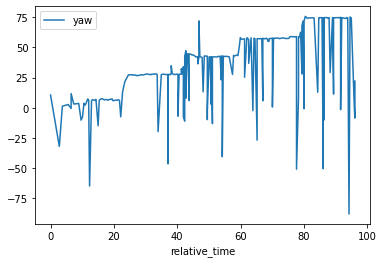

In [71]:
# initial graph
df.plot(x='relative_time', y=target)

In [72]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 5)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [73]:
# the amount of data points we are left with
len(x[peaks])

41

In [74]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='yaw'>

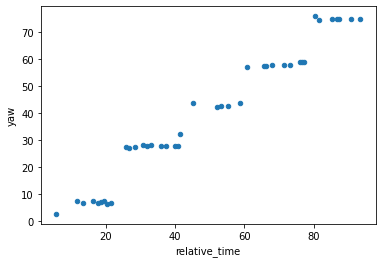

In [75]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [76]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,yaw,true_yaw
3,5.568462,2.687975,0
14,11.752957,7.320103,0
18,13.232170,6.700690,0
26,16.301316,7.529033,0
29,17.695147,6.800951,0
31,18.662870,7.000571,0
33,19.385324,7.423034,0
35,20.437249,6.259803,0
37,21.404996,6.690263,0
43,25.732756,27.375559,30


In [77]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [78]:
# remove huge errors because theyre actually wrongly binned
df_filtered_by_targets = df_filtered_by_targets.drop(df_filtered_by_targets[df_filtered_by_targets['error'].abs()>10].index)

In [79]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [80]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,yaw,true_yaw,error
3,5.568462,2.687975,0,-2.687975
14,11.752957,7.320103,0,-7.320103
43,25.732756,27.375559,30,2.624441
45,26.777807,27.203835,30,2.796165
98,45.085690,43.744290,45,1.255710
121,52.165672,42.157580,45,2.842420
145,60.869514,56.999519,60,3.000481
159,65.742499,57.259163,60,2.740837
207,80.410824,75.719511,75,-0.719511
209,81.442259,74.387471,75,0.612529


In [81]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_yaw,,,,,,,,
0,9.0,-6.490269,1.482796,-7.529033,-7.320103,-6.800951,-6.690263,-2.687975
30,10.0,2.284945,0.302254,1.872234,2.132084,2.205513,2.532054,2.796165
45,5.0,2.073334,0.704210,1.255710,1.395319,2.435490,2.437734,2.842420
60,9.0,2.060851,0.770616,1.028317,1.150238,2.234668,2.724885,3.000481
75,7.0,0.191118,0.420686,-0.719511,0.251695,0.280262,0.330577,0.612529


In [82]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

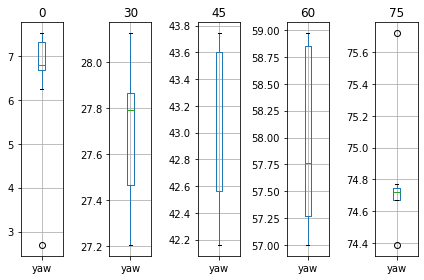

In [83]:
box_plotter(target)

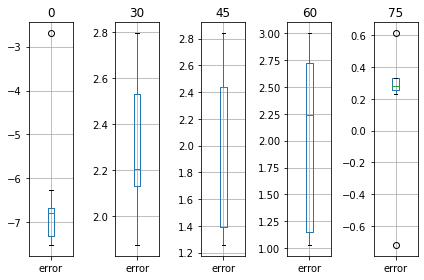

In [84]:
box_plotter('error')